# MNIST Digit Classification Network

## Imports

In [21]:
import math
import random
from abc import ABC, abstractmethod
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join
from sklearn.model_selection import train_test_split

In [22]:
class Operation(ABC):
    def __init__(self, label) -> None:
        self.label = label
    
    @abstractmethod
    def __call__(self, data1, data2):
        raise NotImplementedError
    
    @abstractmethod
    def _backward(self, grad_out):
        raise NotImplementedError

class OperationFactory:
    def __call__(self, op, node1, node2 = None):
        self.op = op
        
        if node2:
            if not isinstance(node2, Value):
                node2 = Value(node2)
            
            def _backward():
                grad1_update, grad2_update = self.op._backward(out.grad)
                node1.grad += grad1_update
                node2.grad += grad2_update
            
            out = Value(self.op(node1.data, node2.data), _childern = (node1, node2), _op = op.label)
            out._backward = _backward
        else:
            def _backward():
                grad1_update, _ = self.op._backward(out.grad)
                node1.grad += grad1_update
            
            out = Value(self.op(node1.data, None), _childern = (node1, ), _op = op.label)
            out._backward = _backward

        return out

class Addition(Operation):
    def __init__(self, label = "add") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        return data1 + data2
    
    def _backward(self, grad_out):
        return (grad_out, grad_out)

class Multiplication(Operation):
    def __init__(self, label = "mul") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        self.data1, self.data2 = data1, data2
        return data1 * data2

    def _backward(self, grad_out):
        return (grad_out * self.data2, grad_out * self.data1)

class Subtraction(Operation):
    def __init__(self, label = "sub") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        return data1 - data2

    def _backward(self, grad_out):
        return (grad_out, grad_out)

class Division(Operation):
    def __init__(self, label = "div") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        if data2 == 0:
            raise ZeroDivisionError

        self.data1, self.data2 = data1, data2
        return data1 / data2
    
    def _backward(self, grad_out):
        return (grad_out / self.data2, - self.data1 * grad_out / (self.data2 ** 2))

class Power(Operation):
    def __init__(self, label = "pow") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        if not isinstance(data2, (int, float)):
            raise TypeError
        
        self.data1, self.data2 = data1, data2
        return data1 ** data2
    
    def _backward(self, grad_out):
        return (grad_out * self.data2 * self.data1 ** (self.data2 - 1), 0.0)

class Exp(Operation):
    def __init__(self, label = "exp") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        self.out = math.exp(data1)
        return math.exp(data1)
    
    def _backward(self, grad_out):
        return (self.out * grad_out, None)

class Tanh(Operation):
    def __init__(self, label = "tanh") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        self.out = math.tanh(data1)
        return self.out
    
    def _backward(self, grad_out):
        return ((1 - self.out ** 2) * grad_out, None)

class ReLU(Operation):
    def __init__(self, label = "relu") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        self.data = data1
        return max(0.0, data1)
    
    def _backward(self, grad_out):
        return (grad_out if self.data > 0.0 else 0.0, None)

class LossFunction(ABC):
    def __init__(self, label) -> None:
        self.label = label

    @abstractmethod
    def __call__(self, data1, data2):
        raise NotImplementedError

class MSE(LossFunction):
    def __init__(self, label = "mse") -> None:
        super().__init__(label)

    def __call__(self, data1, data2):
        return (data1 - data2) ** 2
    
class MAE(LossFunction):
    def __init__(self, label = "mae") -> None:
        super().__init__(label)
    
    def __call__(self, data1, data2):
        return data1 - data2 if data1 > data2 else data2 - data1

class Value:
    def __init__(self, data, label="", _childern = (), _op = '') -> None:
        """
            Value object to store numerical values
            :param data      - numerical value
            :param label     - label for human readability
            :param _childern - all of the childern of the current value node
            :param _op       - operation leading to the current value
        """

        self.data = data
        self.label = label
        self._prev = set(_childern)  # used for backprop (childern is previous)
        self._op = _op
        self.op_fact = OperationFactory()
        self.grad = 0.0  # records the partial derivative of output wrt this node
        self._backward = lambda : None  # used for backpropagation
    
    def __repr__(self) -> str:
        return f"{self.data}"

    def operate(self, other, op):
        out = self.op_fact(op, self, other)
        return out

    def __add__(self, other):
        add = Addition()
        return self.operate(other, add)

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        mul = Multiplication()
        return self.operate(other, mul)

    def __rmul__(self, other):  # other * self
        return self * other    
    
    def __sub__(self, other):
        sub = Subtraction()
        return self.operate(other, sub)

    def __rsub__(self, other):
        return self - other
    
    def __truediv__(self, other):
        division = Division()
        return self.operate(other, division)

    def __pow__(self, other): # self ** other
        pow = Power()
        return self.operate(other, pow)

    def __rpow__(self, other):  # a ^ x
        other = Value(other)
        return other ** self
    
    def exp(self):
        exp = Exp()
        return self.operate(None, exp)

    def __le__(self, other):
        return self.data <= other.data

    def __gt__(self, other):
        return self.data > other.data

    def __lt__(self, other):
        return self.data < other.data
    
    def __ge__(self, other):
        return self.data >= other.data
    
    def __eq__(self, other):
        return self.data == other.data

    def __ne__(self, other):
        return self.data != other.data

    def act(self, func):
        out = self.op_fact(func, self, None)
        return out

    def tanh(self):
        tanh = Tanh()
        return self.act(tanh)

    def relu(self):
        relu = ReLU()
        return self.act(relu)

    def backward(self):
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                topo.append(node)  # WHERE IT MIGHT GO WRONG
                for child in node._prev:
                    build_topo(child)
        
        topo = []
        visited = set()
        self.grad = 1.0
        
        build_topo(self)
        for node in topo:
            node._backward()

In [23]:
class Neuron:
    def __init__(self, n_inputs) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum((w.data*i for w,i in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, n_in, n_out) -> None:
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out
    
    def parameters(self):
        return [param for n in self.neurons for param in n.parameters()]

class MLP:
    def __init__(self, n_input, n_outs) -> None:
        ins = [n_input] + n_outs
        self.layers = [Layer(ins[i], ins[i+1]) for i in range(len(n_outs))]
    
    def __call__(self, x):
        temp = x
        for layer in self.layers:
            temp = layer(temp)
        return temp
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    def zero_grad(self):
        for param in self.parameters():
            param.grad = 0

# TODO: Documentation


## Dataset

In [ ]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

In [7]:
#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

In [6]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = './mnist'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

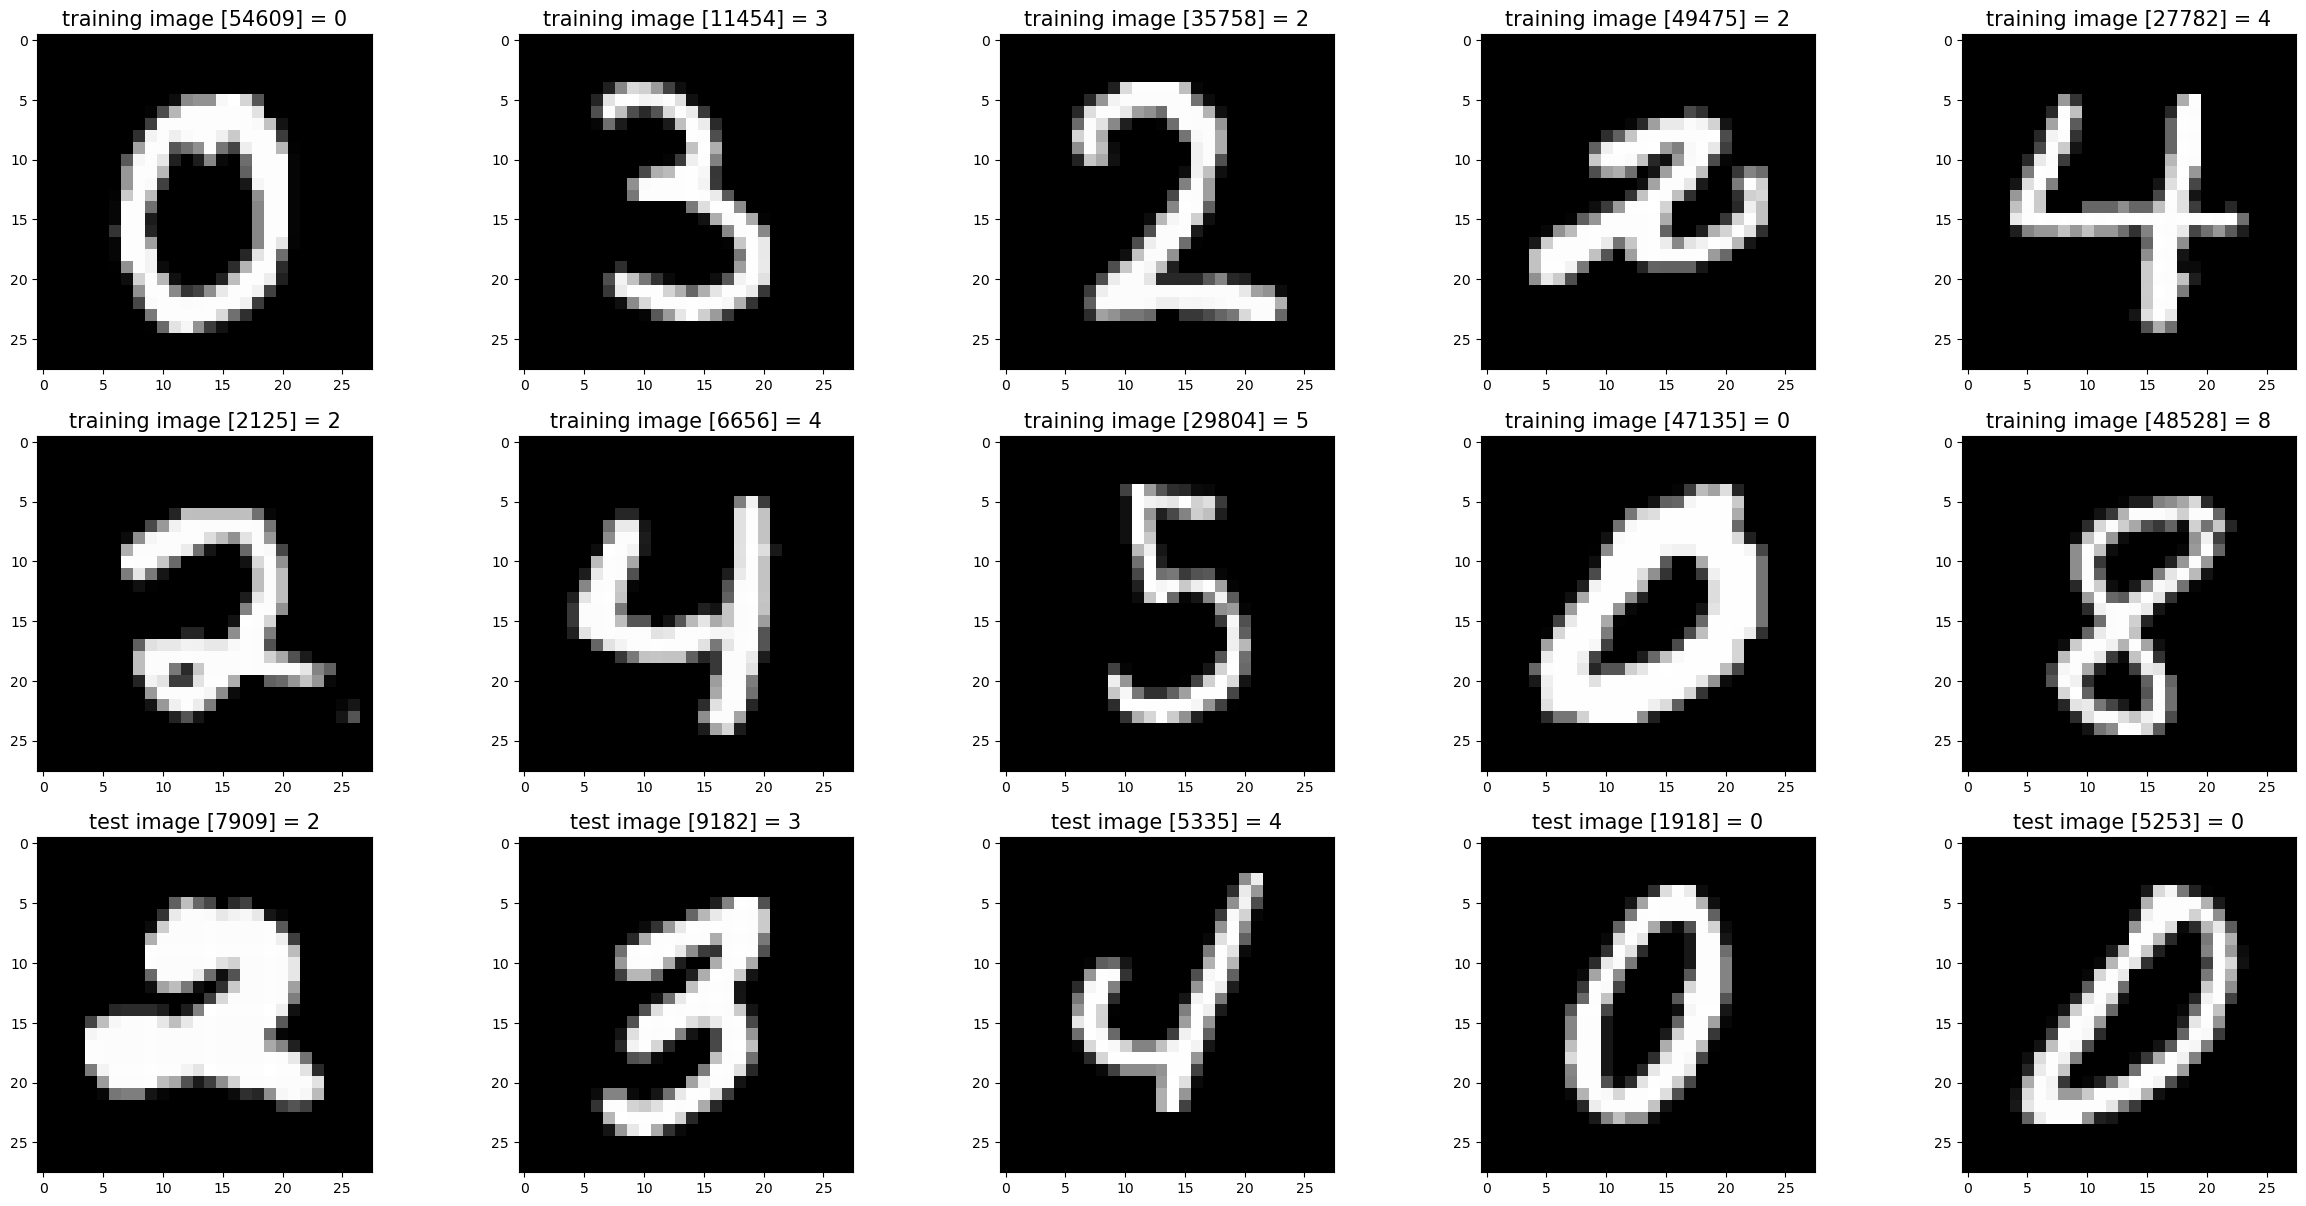

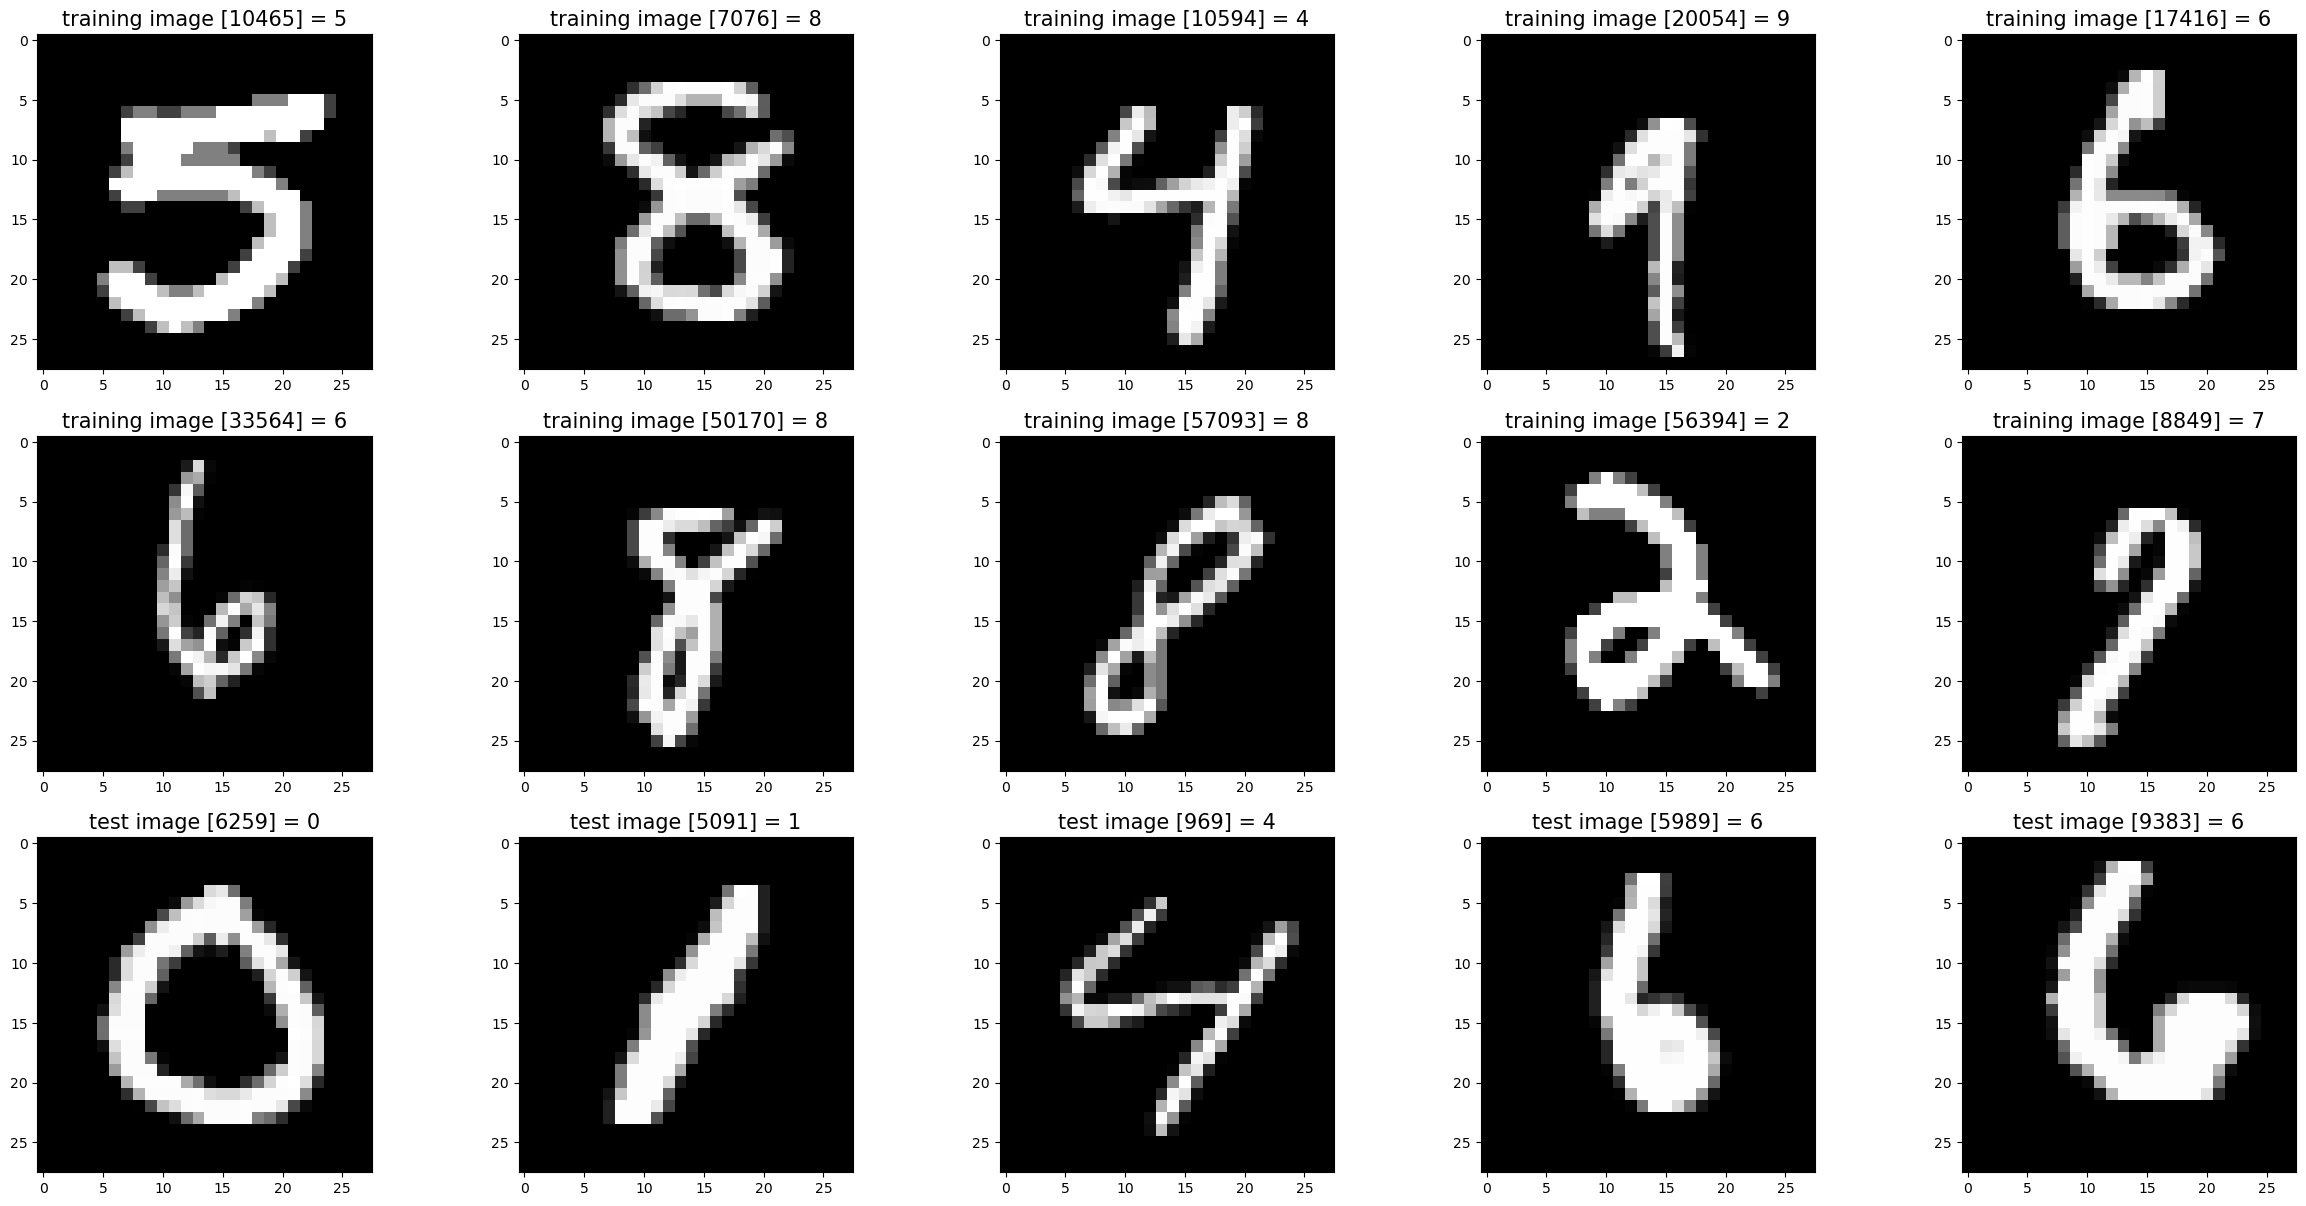

In [8]:
#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

plt.show()

1. ```x_train``` is a list (len 60000) of (28, 28) matrices.
2. ```y_train``` is a list (len 60000) of int values

In [20]:
# (x_train, y_train), (x_test, y_test)

50000 : 10000 : 10000

In [25]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=10000)

28 * 28 -> 14 * 14 -> 7 * 7 -> 3 * 3 -> 1